In [55]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import warnings
import dowhy
from dowhy import CausalModel
warnings.filterwarnings("ignore", category=FutureWarning)


In [56]:
# Load the 30-bus system
net = pn.case30()
# Inspect generators in the system
print(net.gen)
# Define PV buses
pv_buses = [1, 21, 26, 22, 12]

# Fixed means and standard deviations for each PV bus
pv_bus_means = [20.42496, 12.76560, 14.04216, 7.65936, 10.21248]
pv_bus_stds = [25.622111, 16.013819, 17.615201, 9.608292, 12.811055]

   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  21.59    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.20    1.0     NaN       -10.0        40.0      1.0  False   
4  None   12  37.00    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
1        True           0.0  None          True      50.0       0.0  
2        True           0.0  None          True      55.0       0.0  
3        True           0.0  None          True      30.0       0.0  
4        True           0.0  None          True      40.0       0.0  


In [57]:
# Drop specific generators
net.gen.drop(net.gen[net.gen['bus'].isin([21,22])].index, inplace=True)

# Verify the remaining generators
print(net.gen)

   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
4  None   12  37.00    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
2        True           0.0  None          True      55.0       0.0  
4        True           0.0  None          True      40.0       0.0  


In [58]:
installed_capacities =[80, 50, 55, 30, 40]
# Create Static Generators (sgen) for the PV buses
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")
    # Verify static generator table
print(net.sgen)

        name  bus  p_mw  q_mvar  sn_mva  scaling  in_service type  \
0   PV_bus_1    1   0.0     0.0     NaN      1.0        True  wye   
1  PV_bus_21   21   0.0     0.0     NaN      1.0        True  wye   
2  PV_bus_26   26   0.0     0.0     NaN      1.0        True  wye   
3  PV_bus_22   22   0.0     0.0     NaN      1.0        True  wye   
4  PV_bus_12   12   0.0     0.0     NaN      1.0        True  wye   

   current_source  max_p_mw  
0            True      80.0  
1            True      50.0  
2            True      55.0  
3            True      30.0  
4            True      40.0  


In [59]:
n_scenarios = 100  # Number of scenarios
n_runs_per_scenario = 500  # Monte Carlo runs per scenario
scenario_results = []
# Acceptable variation (Assume about from 5% to 10% variation with the original mean and std)
mean_variation = 1
std_variation = 1

In [60]:
# Iterate over scenarios
for scenario in range(n_scenarios):
    scenario_lolps = []  # Store LOLP for each run in this scenario

In [61]:
# Generate scenarios
for scenario in range(n_scenarios):
    # Adjust mean and std for this scenario
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")
    lolp_count = 0  # To count the number of load losses
    scenario_means = [mean * (1 + np.random.uniform(-mean_variation, mean_variation)) for mean in pv_bus_means]
    scenario_stds = [std * (1 + np.random.uniform(-std_variation, std_variation)) for std in pv_bus_stds]
    
    scenario_lolps = []  # Store LOLP for each run in this scenario
    total_solar_generation = []
    total_reactive_power = []
    voltage_deviations = []
    for run in range(n_runs_per_scenario):
        # Sample PV outputs from normal distribution
        pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(scenario_means, scenario_stds)]
        
        # Update PV generation in the network
        for i, bus in enumerate(pv_buses):
            net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
        
        try:
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_solar_generation.append(net.res_sgen['p_mw'].sum())
            total_reactive_power.append(net.res_bus['q_mvar'].sum())
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            
            # Calculate voltage deviation from 1.0 p.u.
            voltage_dev = abs(net.res_bus['vm_pu'] - 1).mean()
            voltage_deviations.append(voltage_dev)
            
            # Calculate LOLP
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_load = net.load['p_mw'].sum()
            lolp = 1 if total_generation < total_load else 0  # Load loss if generation < load
            scenario_lolps.append(lolp)
        except pp.LoadflowNotConverged:
            print(f"Power flow did not converge for scenario {scenario}, run {run}.")
            continue
    
    # Calculate average LOLP for this scenario
    avg_lolp = np.mean(scenario_lolps) if scenario_lolps else None
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    avg_solar_generation = np.mean(total_solar_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)
    
    # Calculate LOLP for this scenario
    lolp = lolp_count / n_runs_per_scenario
    scenario_results.append({
        'Scenario': scenario + 1,
        'PV1 Mean Output': scenario_means[0],
        'PV1 Std Output': scenario_stds[0],
        'PV2 Mean Output': scenario_means[1],
        'PV2 Std Output': scenario_stds[1],
        'PV3 Mean Output': scenario_means[2],
        'PV3 Std Output': scenario_stds[2],
        'PV4 Mean Output': scenario_means[3],
        'PV4 Std Output': scenario_stds[3],
        'PV5 Mean Output': scenario_means[4],
        'PV5 Std Output': scenario_stds[4],
        'Total Solar Generation': avg_solar_generation,
        'Total Reactive Power': avg_reactive_power,
        'Voltage Deviation': avg_voltage_deviation,
        'LOLP': avg_lolp
    })

# Save results to a DataFrame
df_scenario_results = pd.DataFrame(scenario_results)
df_scenario_results.to_excel("100_scenarios_drop2_results.xlsx", index=False)
print("Scenario results saved to '100_scenarios_drop2_results.xlsx'.")

Running Scenario 1/100
Scenario 1: Average LOLP = 0.25
Running Scenario 2/100
Scenario 2: Average LOLP = 0.334
Running Scenario 3/100
Scenario 3: Average LOLP = 0.626
Running Scenario 4/100
Scenario 4: Average LOLP = 0.308
Running Scenario 5/100
Scenario 5: Average LOLP = 0.472
Running Scenario 6/100
Scenario 6: Average LOLP = 0.434
Running Scenario 7/100
Scenario 7: Average LOLP = 0.152
Running Scenario 8/100
Scenario 8: Average LOLP = 0.262
Running Scenario 9/100
Scenario 9: Average LOLP = 0.446
Running Scenario 10/100
Scenario 10: Average LOLP = 0.7
Running Scenario 11/100
Scenario 11: Average LOLP = 0.42
Running Scenario 12/100
Scenario 12: Average LOLP = 0.182
Running Scenario 13/100
Scenario 13: Average LOLP = 0.6
Running Scenario 14/100
Scenario 14: Average LOLP = 0.336
Running Scenario 15/100
Scenario 15: Average LOLP = 0.422
Running Scenario 16/100
Scenario 16: Average LOLP = 0.528
Running Scenario 17/100
Scenario 17: Average LOLP = 0.436
Running Scenario 18/100
Scenario 18: A

In [62]:
data = pd.read_excel('100_scenarios_drop2_results.xlsx')
# View data structure
print(data.head())

   Scenario  PV1 Mean Output  PV1 Std Output  PV2 Mean Output  PV2 Std Output  \
0         1         9.688020       18.715160        21.147565        3.538720   
1         2        23.521519       29.682629         2.657818       28.645455   
2         3         2.471312       25.179394         4.862775       27.487512   
3         4        21.791218       27.689458         4.406548       18.813938   
4         5        13.896451       28.537723        22.068314       22.364334   

   PV3 Mean Output  PV3 Std Output  PV4 Mean Output  PV4 Std Output  \
0        14.225637        8.940702        14.082878        4.731431   
1        14.512117        4.708824         7.927650        9.565691   
2        16.245424        4.379969         9.503328        5.524825   
3         6.233630       33.064235        12.558305        2.347960   
4        10.695372        2.187687         0.744295       12.997640   

   PV5 Mean Output  PV5 Std Output  Total Solar Generation  \
0        18.888920      

Analyzing causal effect of PV1 Mean Output on LOLP:


C:\Users\jliu359\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


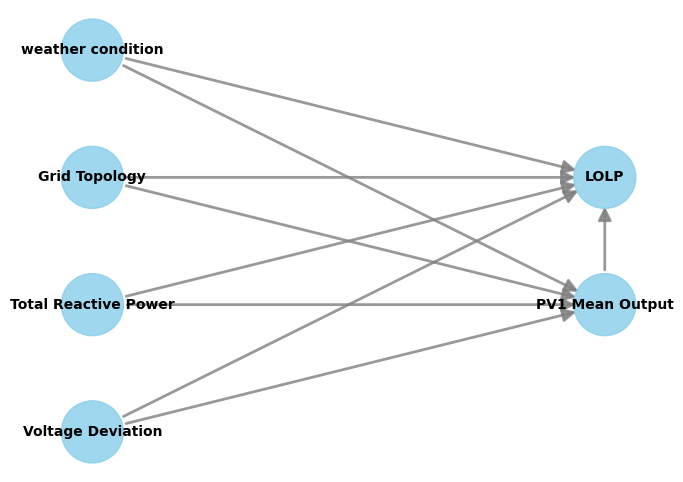

Causal Effect of PV1 Mean Output on LOLP: None


Analyzing causal effect of PV2 Mean Output on LOLP:


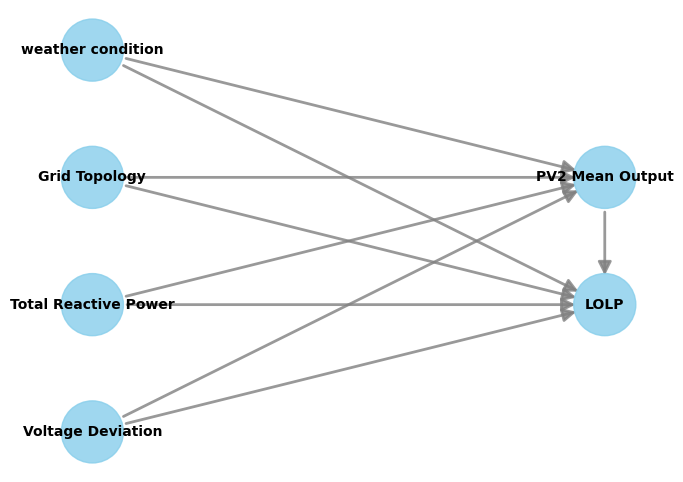

Causal Effect of PV2 Mean Output on LOLP: None


Analyzing causal effect of PV3 Mean Output on LOLP:


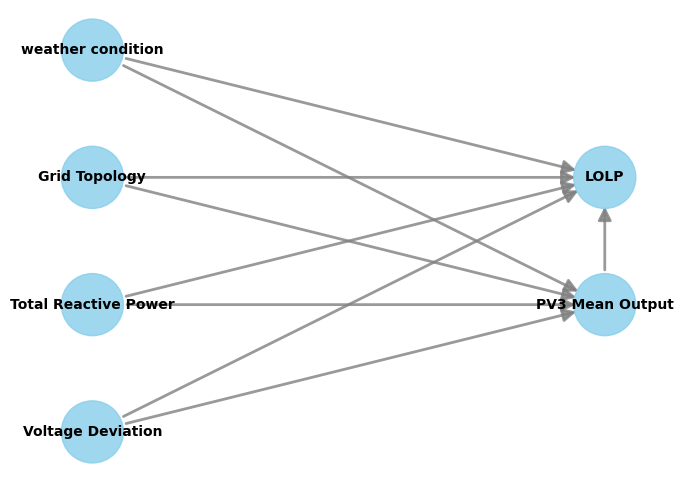

Causal Effect of PV3 Mean Output on LOLP: None


Analyzing causal effect of PV4 Mean Output on LOLP:


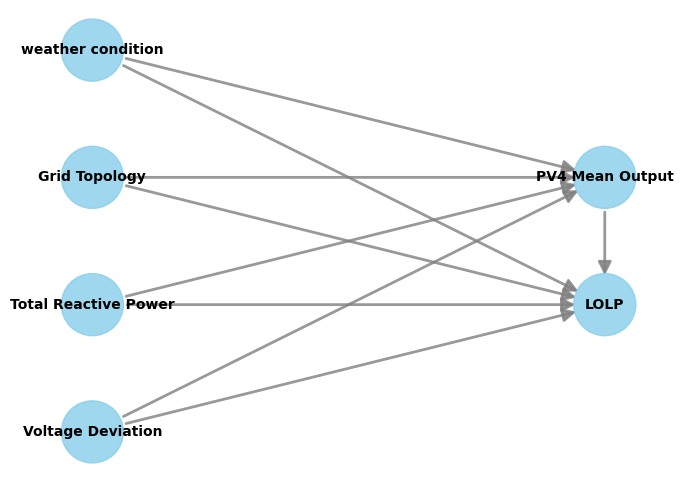

Causal Effect of PV4 Mean Output on LOLP: None


Analyzing causal effect of PV5 Mean Output on LOLP:


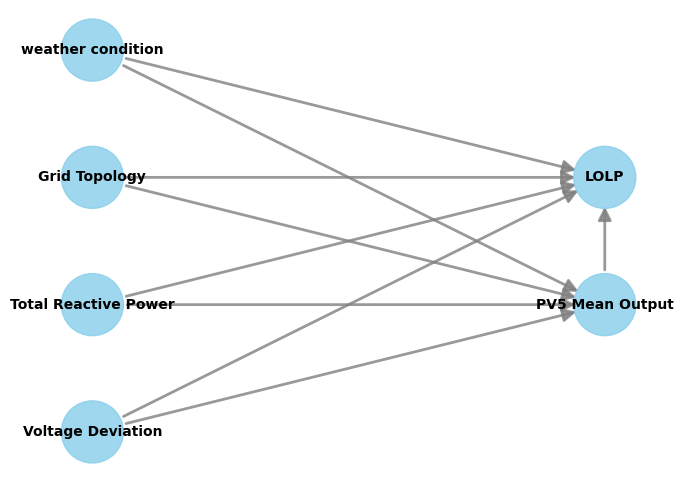

Causal Effect of PV5 Mean Output on LOLP: None


Analyzing causal effect of Total Solar Generation on LOLP:


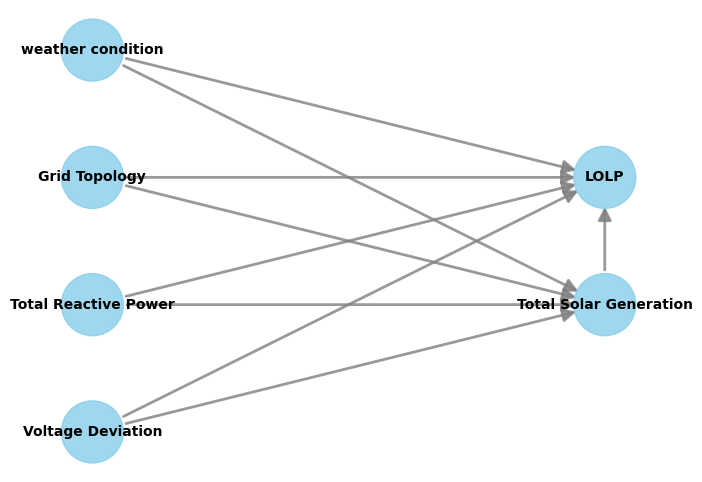

Causal Effect of Total Solar Generation on LOLP: None




In [65]:
# Iterate over each PV bus output as the treatment variable
pv_buses = ['PV1 Mean Output', 'PV2 Mean Output', 'PV3 Mean Output', 'PV4 Mean Output', 'PV5 Mean Output','Total Solar Generation']

for pv_bus in pv_buses:
    print(f"Analyzing causal effect of {pv_bus} on LOLP:")
    # Define the causal model
    model = CausalModel(
    data=data,
    treatment=pv_bus,  # Treatments
    outcome='LOLP',  # Reliability indicator
    common_causes=['Voltage Deviation', 'Total Reactive Power','Grid Topology','weather condition']  # Confounders
    )# Visualize the DAG
    model.view_model()

# Identify and estimate the causal effect
    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    
    print(f"Causal Effect of {pv_bus} on LOLP: {causal_estimate.value}")
    print("\n")
